In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb;
import time
import copy
from numpy import cos,sin,pi

In [2]:
# Robot dimensions
wheel_radius = 0.025
wheel_sep = 0.09
tail_dist = 0.075
L = 0.75
W = 0.5
dt = 0.01

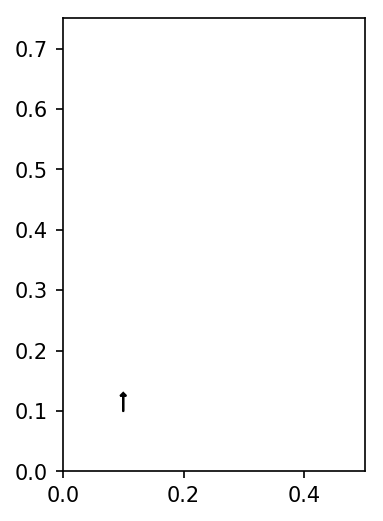

In [3]:
# Plot world
def show_world():
    plt.rcParams['figure.dpi'] = 150
    fig = plt.figure()
    ax=fig.add_subplot(111)
    plt.plot()
    
   
    plt.axis('equal')
    plt.axis([0,W,0,L])
    plt.gca().set_aspect('equal', adjustable='box')
    
    return ax
        
# Plot robot
def plot_robot(state,ax):      
    l = 0.025
    ax.arrow(state[0], state[1], l*np.cos(state[2]+pi/2), l*np.sin(state[2]+pi/2),width = 0.000001, head_width=0.01,head_length = 0.005)
            
  
ax = show_world()
plot_robot([0.1,0.1,0,0],ax)



In [4]:
# Calculated difference between angles
def get_angle_diff(a1,a2):
    ang_cw =  (a2 -a1)% (2*np.pi)
    ang_ccw = (- a2 + a1)% (2*np.pi)
    
    ang = np.minimum(ang_cw,ang_ccw) 
    if ang == ang_ccw:
        ang = - ang
    return ang

# Calculate distance between two points
def get_dist_diff(c1,c2):
    dist = np.sqrt(((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2))
    return dist

print(get_angle_diff(0,0.1))
print(get_angle_diff(0,-0.1))
print(get_angle_diff(0,0))

0.1
-0.1
-0.0


In [5]:
def forward_dynamic(state,controls):
    wl,wr = controls
    x,y,th,w = state
    vr = wr*wheel_radius
    vl = wl*wheel_radius
    wc = (vr-vl)/wheel_sep
    if wl!=wr:
        Rc = wheel_sep/2*(vr+vl)/(vr-vl)
        cx = x - Rc*sin(th+pi/2)
        cy = y + Rc*cos(th+pi/2)
        d = wc*dt
        xd = (x-cx)*cos(d) - (y-cy)*sin(d) + cx
        yd = (x-cx)*sin(d) + (y-cy)*cos(d) + cy
        thd = (th+d)#%(2*pi)
    else:
        v = vr
        d = v*dt
        xd =  x+d*sin(th)
        yd =  y+d*cos(th)
        thd = th
    wd = wc
    return [xd,yd,thd,wd]

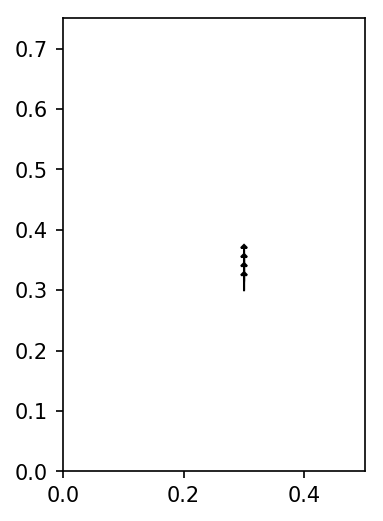

In [6]:
ax = show_world()
state = [0.3,0.3,0,0]
plot_robot(state,ax)
controls = [60,60]
for i in range(3):
    state = forward_dynamic(state,controls)
#     print(state)
    plot_robot(state,ax)

In [7]:
def state_to_sensor(state,noise_std = None):
    get_dist_x = lambda x :  [(x - state[0])/ np.cos(state[2]) , (x - state[0])/ np.cos(state[2]+pi/2)]
    get_dist_y = lambda x :  [(x - state[1])/ np.sin(state[2]), (x - state[1])/ np.sin(state[2]+pi/2)]
    get_line_x = lambda d :  [state[0] + d[0] * np.cos(state[2]) , state[0] + d[1] * np.cos(state[2]+pi/2)]
    get_line_y = lambda d :  [state[1] + d[0] * np.sin(state[2]),  state[1] + d[1] * np.sin(state[2]+pi/2)]


    
    rN,fN = get_dist_y(L)
    xrN,xfN = get_line_x([rN,fN])
 
    rS,fS = get_dist_y(0)
    xrS,xfS = get_line_x([rS,fS])
    
    rW,fW = get_dist_x(W)
    yrW,yfW = get_line_y([rW,fW])
    
    rE,fE = get_dist_x(0)
    yrE,yfE = get_line_y([rE,fE])
    
    def check_x(x):
        return x<=W and x>=0

    def check_y(y):
        return y<=L and y>=0
    
    
    ra =  [rN,rS,rW,rE]
    fa = [fN,fS,fW,fE]
    
    rb = [check_x(xrN) and rN>=0,check_x(xrS) and rS>=0,check_y(yrW) and rW>=0,check_y(yrE) and rE>=0]
    fb = [check_x(xfN) and fN>=0,check_x(xfS) and fS>=0,check_y(yfW) and fW>=0,check_y(yfE) and fE>=0]
    if sum(rb)!=1:
#         print(ra,rb)
        1/0
        r = -1
    else:
        r = ra[rb.index(True)]
        if noise_std is not None:
            r = r + np.sqrt(noise_std[1])* np.random.randn()
        
    if sum(fb)!=1:
        1/0
        f = -1
    else:
        f = fa[fb.index(True)]
        if noise_std is not None:
            f = f + np.sqrt(noise_std[0])* np.random.randn()
    
    th = (state[2]+pi/2)#%(2*pi)
    w = state[3]
    if noise_std is not None:
         th = (th + np.sqrt(noise_std[2])* np.random.randn())#%(2*pi)
         w = w + np.sqrt(noise_std[3])* np.random.randn()
    return [f,r,th,w]

0.75 0.5
[0.3, 0.65, 3.141592653589793, 0]
[0.32671590156285063, 0.6755632195419023, 3.1185466015728918, 0.004495436912074982]


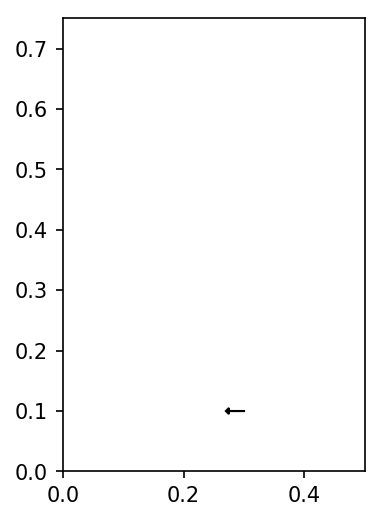

In [8]:
state = [0.3,0.1,np.pi/2,0]
measurement_noise_std = [.001,0.001,0.001,0.001]
print(L,W)
print(state_to_sensor(state))
print(state_to_sensor(state,measurement_noise_std))
ax = show_world()
plot_robot(state,ax)

In [9]:
def trace_traj(state,traj,actuation_noise_std = None,measurement_noise = None):
    state_seq = []
    obs_seq = []
    for c in traj:
        if actuation_noise_std is not None:
            c[0] += actuation_noise_std[0]*np.random.randn()
            c[1] += actuation_noise_std[1]*np.random.randn()
        obs = state_to_sensor(state,measurement_noise)
        state = forward_dynamic(state,c)
        
#         print(state)
        obs_seq.append(obs)
        state_seq.append(state)
    return (state_seq,obs_seq)

def plot_state_seq(states):
    ax = show_world()
    for state in states:
#         print(state)
        plot_robot(state,ax)

/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


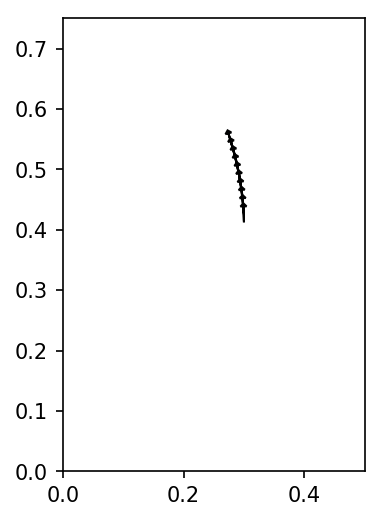

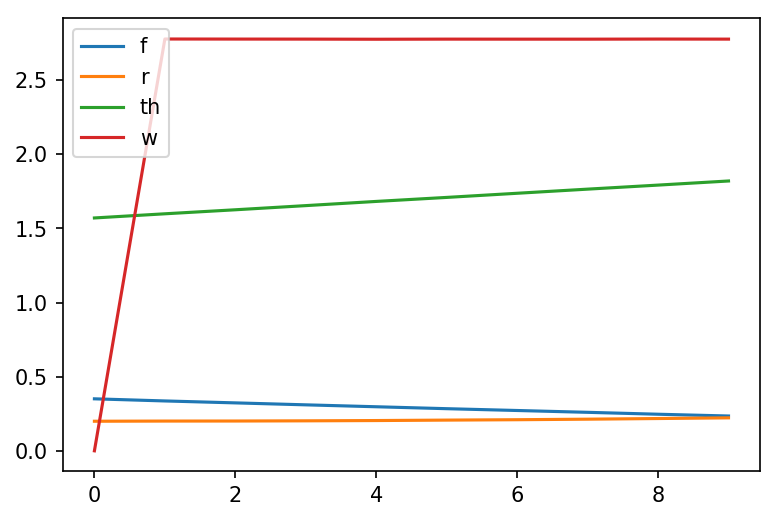

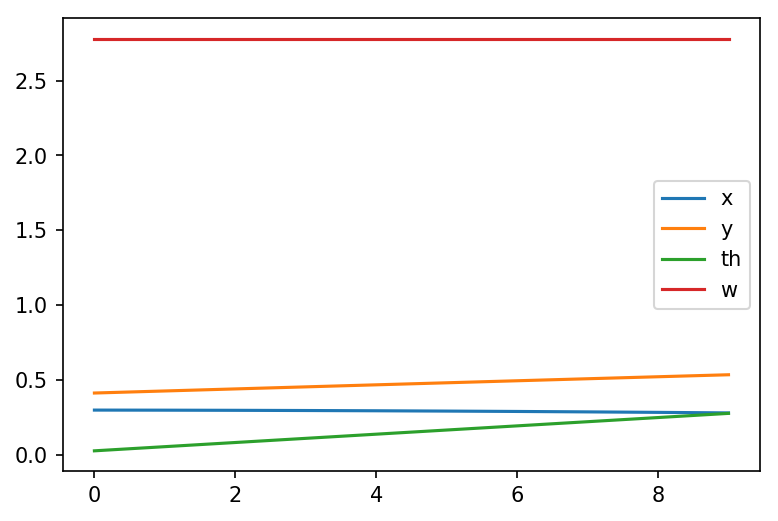

In [10]:
control_seq = [[50,60]]*10
init_state = [0.3,0.4,0,0]
actuation_noise_std = np.ones((2,))*1e-7
measurement_noise_std = np.ones((4,))*1e-7
measure_noise_cov = np.diag(measurement_noise_std)
state_noise_cov = np.diag(measurement_noise_std)

state_seq,obs_seq = trace_traj(init_state,control_seq,actuation_noise_std,measurement_noise_std)
plot_state_seq(state_seq)
plt.figure()
plt.plot(np.array(obs_seq))
plt.legend(['f','r','th','w'])
plt.figure()
plt.plot(np.array(state_seq))
plt.legend(['x','y','th','w'])

In [11]:
def calculate_sigma_points(state_mean,actuation_noise_cov,spreading = 3):
    state_mean = np.array(state_mean )
    sqrt_activ_noise_cov = np.linalg.cholesky(actuation_noise_cov)
    state_dim = len(state_mean)
    X = np.zeros((state_dim,state_dim*2+1))
    X[:,0] = state_mean
    X[:,1:state_dim+1] =  state_mean[:,None] + np.sqrt(state_dim+spreading)*sqrt_activ_noise_cov
    X[:,state_dim+1:] = state_mean[:,None]  - np.sqrt(state_dim+spreading)*sqrt_activ_noise_cov
    return X

sigma_test = calculate_sigma_points(init_state,np.diag(measurement_noise_std))
print(sigma_test[:,0:3])

[[0.3        0.30083666 0.3       ]
 [0.4        0.4        0.40083666]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


In [12]:
def predict(sigma_points,control_input,actuation_noise_cov,spreading = 3,forward_fun=forward_dynamic): 
    sigma_pred = np.zeros_like(sigma_points)
    state_dim,nsigma = sigma_points.shape
    sigma_pred[:,0] = forward_fun(sigma_points[:,0].tolist(),control_input)
    for i in range(1,nsigma):
        sigma_pred[:,i] =  forward_fun(sigma_points[:,i],control_input)
    W = np.zeros((nsigma))
#     print(sigma_pred[0,:])
    W[0] = spreading/(state_dim+spreading)
    W[1:] = 1/(2*(state_dim+spreading))
    mean_pred = np.sum(sigma_pred*W,axis = 1)
    cov_pred = np.zeros((state_dim,state_dim))
    for i in range(nsigma):
        cov_pred += np.outer(sigma_pred[:,i]-mean_pred,sigma_pred[:,i]-mean_pred)*W[i]
#     print(sigma_pred[:,0:3])
    cov_pred += actuation_noise_cov
    return mean_pred,cov_pred,sigma_pred

# print(forward_dynamic([0.3,0.4,0,0],[6,6]))
c_state_mean,c_state_cov,c_state_pred = predict(sigma_test,control_seq[0],np.diag(measurement_noise_std))
print(state_seq[0])
print(c_state_mean)
print(c_state_cov)



[0.2998090400596026, 0.413748231796297, 0.02777777742857842, 2.777777742857842]
[0.29980904 0.41374823 0.02777778 2.77777787]
[[ 2.00018901e-07  2.62536065e-13 -1.37482302e-09  0.00000000e+00]
 [ 2.62536065e-13  2.00000004e-07 -1.90959927e-11  0.00000000e+00]
 [-1.37482302e-09 -1.90959927e-11  2.00000000e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-07]]


In [13]:
def update(sigma_points,measurement_noise_cov,spreading = 3,measurement_fun = state_to_sensor): 
    state_dim,nsigma = sigma_points.shape
    measurement_dim = 4
    sigma_pred = np.zeros((measurement_dim,nsigma))
    for i in range(nsigma):
        sigma_pred[:,i] =  measurement_fun(sigma_points[:,i])
#     print(sigma_pred[:,0:3])
    W = np.zeros((nsigma,))
    W[0] = spreading/(state_dim+spreading)
    W[1:] = 1/(2*(state_dim+spreading))
    mean_pred = np.sum(sigma_pred*W,axis = 1)
    cov_pred = np.zeros((state_dim,state_dim))
    for i in range(nsigma):
        cov_pred += np.outer(sigma_pred[:,i]-mean_pred,sigma_pred[:,i]-mean_pred)*W[i]
    cov_pred+=measurement_noise_cov
    return mean_pred,cov_pred,sigma_pred
c_measure_mean,c_measure_cov,c_measure_pred = update(sigma_test,measure_noise_cov)
print(obs_seq[0])
print(c_measure_mean)
print(c_measure_cov)

[0.3506738617656997, 0.19939929132907322, 1.5710299147292024, -0.00018781595870651213]
[0.35000002 0.20000001 1.57079633 0.        ]
[[2.00000002e-07 1.05000061e-15 0.00000000e+00 0.00000000e+00]
 [1.05000061e-15 2.00000001e-07 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.00000000e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-07]]


/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
def calc_kalman_gain(state_pred,state_mean,measure_pred,measure_mean,measure_cov,spreading = 3):
    state_dim,nsigma = state_pred.shape
    cov_pred = np.zeros((state_pred.shape[0],measure_pred.shape[0]))
    W = np.zeros((nsigma,))
    W[0] = spreading/(state_dim+spreading)
    W[1:] = 1/(2*(state_dim+spreading))
    for i in range(nsigma):
        cov_pred += np.outer(state_pred[:,i]-state_mean,measure_pred[:,i]-measure_mean)*W[i]
    return cov_pred@np.linalg.inv(measure_cov)

kalman_gain = calc_kalman_gain(c_state_pred,c_state_mean,c_measure_pred,c_measure_mean,c_measure_cov)
print(kalman_gain)
# 

[[ 2.63001420e-09 -4.99999998e-01 -6.87411512e-03  0.00000000e+00]
 [-4.99999996e-01  2.41877798e-09 -9.54799637e-05  0.00000000e+00]
 [ 2.54975720e-21 -2.73982084e-22  5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [15]:
def kalman_update(pred_state,state_cov,pred_measure,measure_cov,  actual_measure ,kalman_gain):
#     print(locals())
    state = pred_state + kalman_gain@(actual_measure - pred_measure)
    cov = state_cov - kalman_gain@measure_cov@kalman_gain.T
    return (state,cov)
kalman_update(c_state_mean,c_state_cov,c_measure_mean,c_measure_cov,  obs_seq[0] ,kalman_gain)

(array([0.30010779, 0.41341129, 0.02789457, 2.77777787]),
 array([[ 1.50009451e-07,  1.31510392e-13, -6.87411512e-10,
          0.00000000e+00],
        [ 1.31510392e-13,  1.50000002e-07, -9.54799637e-12,
          0.00000000e+00],
        [-6.87411512e-10, -9.54799637e-12,  1.50000000e-07,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e-07]]))

In [16]:
def kalman_step(state_noise_cov,measure_noise_cov,init_state, init_cov ,actual_measure, control_ip,spreading = 3,
               forward_fun=forward_dynamic,measurement_fun = state_to_sensor ):
#     print(locals())
    sigma_test = calculate_sigma_points(init_state,state_noise_cov,spreading=spreading)
    c_state_mean,c_state_cov,c_state_pred = predict(sigma_test,control_ip,state_noise_cov,spreading=spreading,
                                                   forward_fun=forward_fun)
    c_measure_mean,c_measure_cov,c_measure_pred = update(sigma_test,measure_noise_cov,spreading=spreading,
                                                        measurement_fun = measurement_fun)
    kalman_gain = calc_kalman_gain(c_state_pred,c_state_mean,c_measure_pred,c_measure_mean,c_measure_cov,spreading)
    op_state,op_cov=kalman_update(c_state_mean,c_state_cov,c_measure_mean,c_measure_cov,actual_measure ,kalman_gain)
    return op_state,op_cov

# state_noise_cov = 1e-3*np.diag(np.ones(4))
# measure_noise_cov = 1e-3*np.diag(np.ones(4))
# control_ip = [6,6]
# init_state = [0.3,0.4,0,0]
actual_measure = state_to_sensor(init_state,measurement_noise_std)
init_cov = state_noise_cov
print(state_seq[0])
kalman_step(state_noise_cov,measure_noise_cov,init_state, init_cov ,obs_seq[0],control_seq[0])

[0.2998090400596026, 0.413748231796297, 0.02777777742857842, 2.777777742857842]


/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0.30010779, 0.41341129, 0.02789457, 2.77777787]),
 array([[ 1.50009451e-07,  1.31510392e-13, -6.87411512e-10,
          0.00000000e+00],
        [ 1.31510392e-13,  1.50000002e-07, -9.54799637e-12,
          0.00000000e+00],
        [-6.87411512e-10, -9.54799637e-12,  1.50000000e-07,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e-07]]))

In [17]:
def apply_kalman(obs_seq,control_seq,init_state,init_cov,state_noise_cov,measure_noise_cov,spreading = 3,
                forward_fun=forward_dynamic,measurement_fun = state_to_sensor):
    pred_state_seq = []
    c_state = np.array(init_state)
    c_cov = init_cov
    for i in range(len(obs_seq)):
#         print(i)
        c_state,c_cov= kalman_step(state_noise_cov,measure_noise_cov,c_state, c_cov ,obs_seq[i],control_seq[i],spreading = spreading,
                                  forward_fun=forward_fun,measurement_fun = measurement_fun)
#         c_state[2] = c_state[2]#%(2*pi)
#         print(c_state)
        
        pred_state_seq.append(c_state)
    return pred_state_seq
init_cov = np.zeros((4,4))
state_noise_cov = np.diag(measurement_noise_std)**2
measure_noise_cov = np.diag(measurement_noise_std)**2
pred_states = apply_kalman(obs_seq,control_seq,init_state,init_cov,state_noise_cov,measure_noise_cov,spreading = 1)


/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


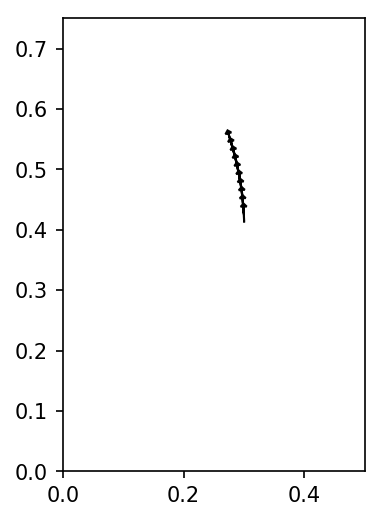

In [18]:
plt_states = pred_states
# print(pred_states)
# print(state_seq)
plot_state_seq(plt_states)

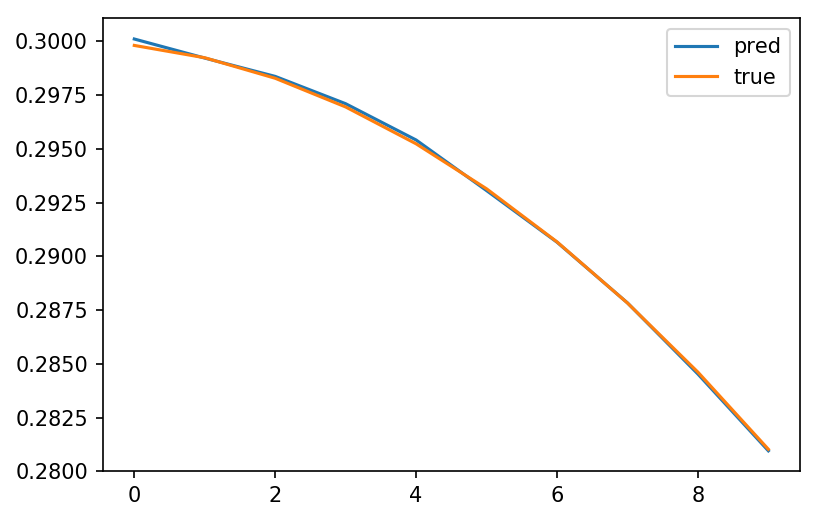

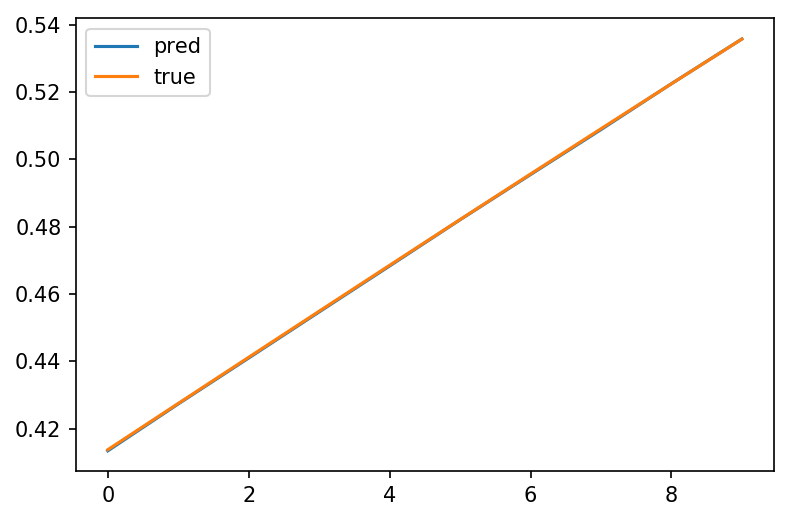

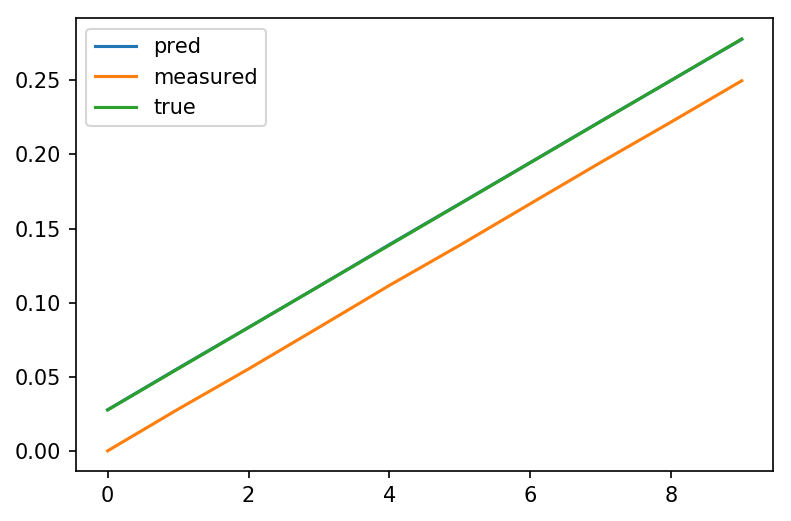

In [19]:
def eval_states(pred_states,state_seq,obs_seq):
    m_pred_states = np.array(pred_states)
    m_true_states = np.array(state_seq)
    m_obs_seq = np.array(obs_seq)
    plt.figure()
    plt.plot(m_pred_states[:,0])
    plt.plot(m_true_states[:,0])
    plt.legend(['pred','true'])
    plt.figure()
    plt.plot(m_pred_states[:,1])
    plt.plot(m_true_states[:,1])
    plt.legend(['pred','true'])
    plt.figure()
    plt.plot(m_pred_states[:,2])
    plt.plot(m_obs_seq[:,2]-pi/2)
    plt.plot(m_true_states[:,2])
    
    plt.legend(['pred','measured','true'])
#     plt.figure()
#     plt.plot(pred_states)
#     plt.legend(['x','y','th','w'])
#     plt.figure()
#     plt.plot(m_true_states)
#     plt.legend(['x','y','th','w'])
eval_states(pred_states,state_seq,obs_seq)

In [108]:
# actuation_noise_std = np.ones((2,))*1e-3


def get_state_cov(control_ip,actuation_noise_cov,spreading = 3,forward_fun = forward_dynamic):
#     print(actuation_noise_cov)
    sigma_points = calculate_sigma_points(control_ip,actuation_noise_cov,spreading = spreading)
    control_dim,nsigma = sigma_points.shape
    control_ip = np.array(control_ip)
    state_dim = 4
    sigma_pred = np.zeros((state_dim,nsigma))
    for i in range(nsigma):
        sigma_pred[:,i] = forward_fun(np.array([0,0,0,0]),sigma_points[:,i])
    W = np.zeros((nsigma,))
    W[0] = spreading/(state_dim+spreading)
    W[1:] = 1/(2*(state_dim+spreading))
    mean_pred = np.sum(sigma_pred*W,axis = 1)
    cov_pred = np.zeros((state_dim,state_dim))
    for i in range(nsigma):
        cov_pred += np.outer(sigma_pred[:,i]-mean_pred,sigma_pred[:,i]-mean_pred)*W[i]
    cov_pred += np.diag(np.ones(state_dim))*1e-10
    return mean_pred,cov_pred
actuation_noise_cov = np.diag(actuation_noise_std)
_,pred_state_cov = get_state_cov(control_seq[0],actuation_noise_cov,spreading = 3)
print(pred_state_cov)
np.linalg.cholesky(pred_state_cov)

[[ 2.22628007e-09 -1.53082313e-07 -3.09296988e-07 -3.09296988e-05]
 [-1.53082313e-07  1.10213174e-05  2.22679499e-05  2.22679499e-03]
 [-3.09296988e-07  2.22679499e-05  4.49916456e-05  4.49915456e-03]
 [-3.09296988e-05  2.22679499e-03  4.49915456e-03  4.49915456e-01]]


array([[ 4.71834725e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.24440539e-03,  7.03669711e-04,  0.00000000e+00,
         0.00000000e+00],
       [-6.55519766e-03,  1.42144997e-03,  2.25666951e-05,
         0.00000000e+00],
       [-6.55519766e-01,  1.42144997e-01,  1.81353861e-03,
         8.96512690e-04]])

array([[ 1.21999840e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.78342292e-03,  1.94454354e-06,  0.00000000e+00,
         0.00000000e+00],
       [-1.77465723e-02, -5.05206270e-10,  3.57124564e-07,
         0.00000000e+00],
       [-1.77465723e+00, -5.05195119e-08,  3.57124442e-05,
         2.98023224e-08]])

In [113]:
def apply_kalman2(obs_seq,control_seq,init_state,init_cov,actuation_noise_cov,measure_noise_cov,spreading = 3,
                forward_fun=forward_dynamic,measurement_fun = state_to_sensor):
    pred_state_seq = []
    c_state = np.array(init_state)
    c_cov = init_cov
    
    
    for i in range(len(obs_seq)):
#         print(i)
#         print(actuation_noise_cov)
        _,state_noise_cov = get_state_cov(control_seq[i],actuation_noise_cov,spreading = 3)
#         print(state_noise_cov)
#         np.linalg.cholesky(state_noise_cov)
        c_state,c_cov= kalman_step(state_noise_cov,measure_noise_cov,c_state, c_cov ,obs_seq[i],control_seq[i],spreading = spreading,
                                  forward_fun=forward_fun,measurement_fun = measurement_fun)
#         c_state[2] = c_state[2]#%(2*pi)
#         print(c_state)
        
        pred_state_seq.append(c_state)
    return pred_state_seq
init_cov = np.zeros((4,4))
actuation_noise_cov = np.diag(actuation_noise_std)**2
measure_noise_cov = np.diag(measurement_noise_std)**2
pred_states = apply_kalman2(obs_seq,control_seq,init_state,init_cov,actuation_noise_cov,measure_noise_cov,spreading = 3)

/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
control_seq = [[6,6]]*100
init_state = [0.3,0.4,0,0]
actuation_noise_std = np.ones((2,))*1e-3
measurement_noise_std = np.ones((4,))*1e-5
measure_noise_cov = np.diag(measurement_noise_std)
state_noise_cov = np.diag(measurement_noise_std)

state_seq,obs_seq = trace_traj(init_state,control_seq,actuation_noise_std,measurement_noise_std)
plot_state_seq(state_seq)
# plt.figure()
# plt.plot(np.array(obs_seq))
# plt.legend(['f','r','th','w'])
# plt.figure()
# plt.plot(np.array(state_seq))
# plt.legend(['x','y','th','w'])


init_cov = np.zeros((4,4))
actuation_noise_cov = np.diag(actuation_noise_std)**2
state_noise_cov = np.diag(measurement_noise_std)**2
measure_noise_cov = np.diag(measurement_noise_std)**2

pred_states = apply_kalman(obs_seq,control_seq,init_state,init_cov,state_noise_cov,measure_noise_cov,spreading = 1)
plot_state_seq(pred_states)

eval_states(pred_states,state_seq,obs_seq)

pred_states2 = apply_kalman2(obs_seq,control_seq,init_state,init_cov,actuation_noise_cov,measure_noise_cov,spreading = 1)
plot_state_seq(pred_states2)

eval_states(pred_states2,state_seq,obs_seq)
eval_states(pred_states,pred_states2)

/home/samer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: eval_states() missing 1 required positional argument: 'obs_seq'

In [ ]:
# def fx(x, dt):
#     # state transition function - predict next state based
#     # on constant velocity model x = vt + x_0
#     F = np.array([[1, dt, 0, 0],
#                   [0, 1, 0, 0],
#                   [0, 0, 1, dt],
#                   [0, 0, 0, 1]], dtype=float)
#     return np.dot(F, x)
# def hx(x):
#    # measurement function - convert state into a measurement
#    # where measurements are [x_pos, y_pos]
#    return np.array([x[0], x[2]])
# z_std = 0.1
# obs_seq = [[i+np.random.randn()*z_std, i+np.random.randn()*z_std] for i in range(50)] # measurements

# measure_noise_cov = np.diag([z_std,z_std])**2
# state_noise_cov = np.diag([z_std,z_std,z_std,z_std])**2
# plt.plot(zs)
# init_state = [0,1,0,1]

# pred_states = apply_kalman(obs_seq,init_state,init_cov,state_noise_cov,measure_noise_cov,spreading = 3,
#                 forward_fun=fx,measurement_fun = hx)

In [ ]:
for _ in range(100):
    print()